In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (12, 12)}) # Set default figure size
sns.set_style("darkgrid")

pd.options.display.float_format = "{:.4f}".format # Pandas significant digits

In [2]:
from IPython.display import display_html

"""
Display pandas dataframes side by side
"""
def display_side_by_side(*args):

    html_str=''

    for df in args:
        html_str+=df.to_html()

    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
df = pd.read_csv("five/ROL.csv", delimiter=";")

In [4]:
df["Applied to first"] = (df["Application"] == df["ROL 1"]).apply(int)

In [5]:
roundcols = [col for col in df.columns if "round" or "Points" in col]

In [6]:
for col in roundcols:
    df[col] = df[col].apply(lambda point: float(str(point).replace(",", ".")))

In [7]:
N, K = df.shape

### Excercise 1

Which fraction of the students does not apply to the most preferred school?
Does this differ by test score, gender and household income?

In [8]:
rel_columns = ["Test score", "Female", "Low Income"]

In [9]:
didapply = df[df["Applied to first"] == 1][rel_columns]
didnotapply = df[df["Applied to first"] == 0][rel_columns]

statistics = ["count", "mean", "std"]

display_side_by_side(
    didapply.describe().loc[statistics], 
    didnotapply.describe().loc[statistics]
)

,Test score,Female,Low Income
count,1054.0000,1054.0000,1054.0000
mean,546.8444,0.4867,0.2723
std,3.0774,0.5001,0.4454
,Test score,Female,Low Income
count,70.0000,70.0000,70.0000
mean,544.1714,0.4857,0.2857
std,4.1667,0.5034,0.4550


In [10]:
isfemale = df["Female"] == 1
islowincome = df["Low Income"] == 1

In [11]:
def kdeplot(df, title, ax, legend=False):
    g = sns.kdeplot(
        data=df, x="Test score", hue="Applied to first", 
        palette="crest", alpha=.5, linewidth=0., fill=True,
        common_norm=False, ax=ax)

    if not legend: ax.legend([], [], frameon=False)

    ax.set_title(title)


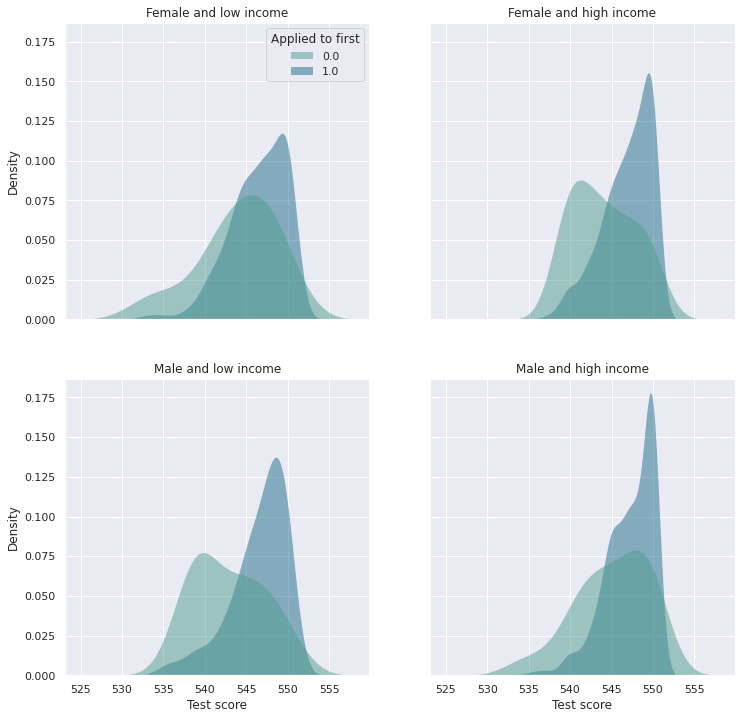

In [12]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

kdeplot(df[isfemale & islowincome], "Female and low income", axes[0, 0], legend=True)
kdeplot(df[isfemale & ~islowincome], "Female and high income", axes[0, 1])
kdeplot(df[~isfemale & islowincome], "Male and low income", axes[1, 0])
kdeplot(df[~isfemale & ~islowincome], "Male and high income", axes[1, 1])

fig.show()

### Exercise 2

Relate the decision not to apply to the most preferred school to the ad-
mission probability and to the difference in utility (points) between the
most-preferred school and the second most-preferred school.

In [13]:
from statsmodels.discrete.discrete_model import Logit, LogitResults

In [14]:
X = np.zeros((N, 2))

X[:, 0] = df["P1 round 1"]
X[:, 1] = df["Points 1"] - df["Points 2"]
X = pd.DataFrame(X, columns=["Acceptance prob.", "Point differential"])

y = df["Applied to first"]



In [15]:
model = Logit(y, X)
res = model.fit()

print(res.summary())



Optimization terminated successfully.
         Current function value: 0.208235
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       Applied to first   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1122
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                  0.1070
Time:                        12:19:24   Log-Likelihood:                -234.06
converged:                       True   LL-Null:                       -262.10
Covariance Type:            nonrobust   LLR p-value:                 6.902e-14
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Acceptance prob.       2.8421      0.194     14.674      0.000       2.463       3.222
Point

### Exercise 3

Compute the expect utility (points) when applying to the most preferred
school. Assume that for the second and third round students make the
optimal choice. What is the average expected utility over all students?

In [16]:
choices = [col for col in df.columns if "Points" in col]

First we find the naive expected utilitites of all rounds, namely,

\begin{equation}
    E[U^j_i] = U_i \cdot P^j_i, \ j \in \{1, 2\}, \ i \in N
\end{equation}

In [17]:
eu_round2 = np.zeros((N, len(choices)))
eu_round3 = eu_round2.copy()
 
for i, points in enumerate(choices):
    prob_round2 = f"P{i + 1} round 2"
    prob_round3 = f"P{i + 1} round 3"

    eu_round2[:, i] = df[points] * df[prob_round2]
    eu_round3[:, i] = df[points] * df[prob_round3]


Then we find the argmax for each round in order to obtain the corresponding probability,

\begin{equation}
P(\underbrace{\arg\max_i E[U^j_i]}_{\text{Max expected}}, \underbrace{j}_{round})
\end{equation}

In [18]:
eu1 = df["Points 1"] * df["P1 round 1"]

opt_choice2 = np.expand_dims(np.argmax(eu_round2, axis = 1), axis = 1)
opt_choice3 = np.expand_dims(np.argmax(eu_round3, axis = 1), axis = 1)

eu2 = np.take_along_axis(eu_round2, opt_choice2, axis = 1).flatten()
eu3 = np.take_along_axis(eu_round3, opt_choice3, axis = 1).flatten()

prob1 = df["P1 round 1"]
prob2 = np.array([df.loc[i, f"P{opt_choice2[i, 0] + 1} round 2"] for i in range(N)])

Finally we construct the expected probability in a recursive manner,

\begin{equation}
    E[U^1_1] = P(1, 1) \cdot U(1, 1) + (1 - P(1, 1)) \cdot \left[ P(i_2^*, 2) \cdot U(i_2^*, 2) + (1- P(i_2^*, 2)) \cdot \left( P(i_3^*, 3) \cdot U(i_3^*, 3) \right) \right]
\end{equation}

In [19]:
expected_utility = \
    prob1 * eu1 + \
        (1 - prob1) * (prob2 * eu2 + \
            (1 - prob2) * eu3)

df["Expected Utility"] = expected_utility


In [20]:
def histplot(df, title, ax, legend=False):

    g = sns.histplot(
        data=df, x="Expected Utility", hue="Applied to first", stat="probability",
        fill=True, multiple="stack", bins = 25,
        common_norm=False, ax=ax)

    if not legend: ax.legend([], [], frameon=False)

    ax.set_title(title)

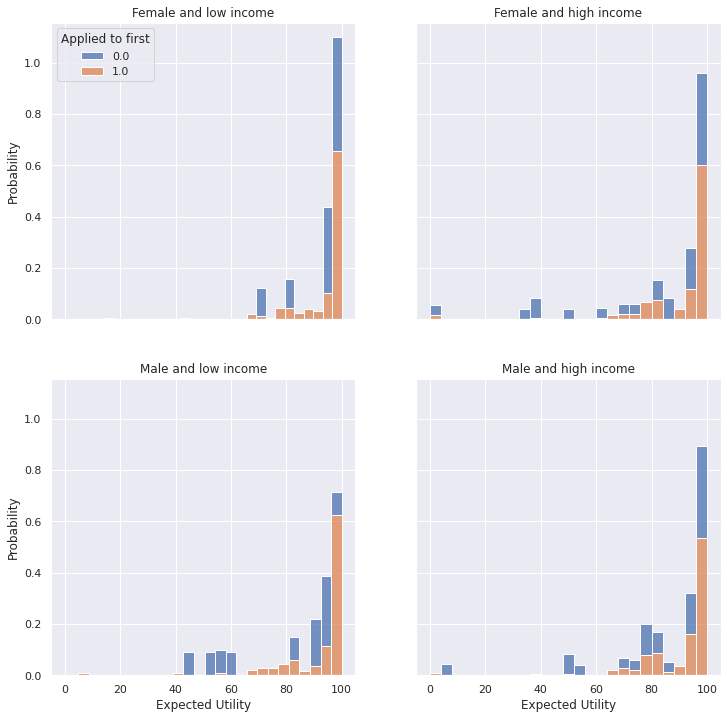

In [21]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

histplot(df[isfemale & islowincome], "Female and low income", axes[0, 0], legend=True)
histplot(df[isfemale & ~islowincome], "Female and high income", axes[0, 1])
histplot(df[~isfemale & islowincome], "Male and low income", axes[1, 0])
histplot(df[~isfemale & ~islowincome], "Male and high income", axes[1, 1])

fig.show()

### Exercise 4

What is the optimal first round application?
And what is the average
expected utility over all students when all students apply optimal (assume
that changing the first round application does not affect the admission
probabilities).